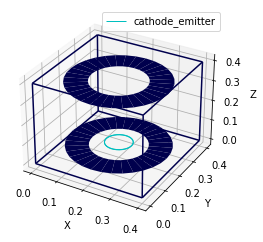

In [41]:
%matplotlib inline
from ef.config.config import Config
from ef.config.visualizer import Visualizer3d
conf = Config.from_fname('pot.conf')
conf.visualize_all(Visualizer3d())

In [42]:
from ef.runner import Runner
Runner(conf.make(),
       output_writer=conf.output_file.make()).start()

  Detected a Hermitian matrix
Writing initial fields to file
Writing to file pot_fieldsWithoutParticles.h5
Writing step 0 to file
Writing to file pot_0000000.h5
Time step from 100 to 101 of 101
Writing step 101 to file
Writing to file pot_0000101.h5


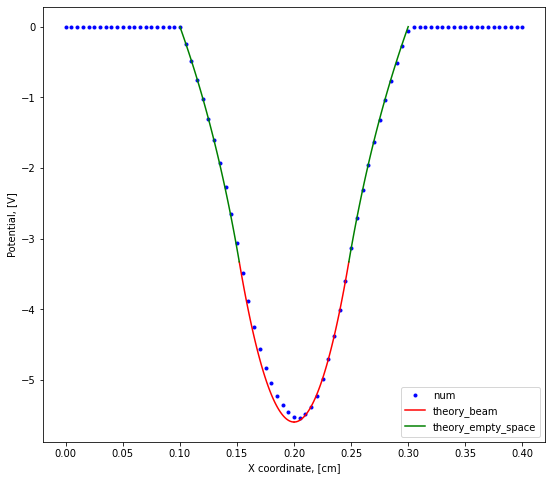

In [43]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def get_source_parameters(h5file):
    radius_beam = h5file["/ParticleSources/cathode_emitter"].attrs["cylinder_radius"]
    charge = h5file["/ParticleSources/cathode_emitter"].attrs["charge"]
    mass = h5file["/ParticleSources/cathode_emitter"].attrs["mass"]
    momentum_z = h5file["/ParticleSources/cathode_emitter"].attrs["mean_momentum_z"]
    particle_per_step = h5file["/ParticleSources/cathode_emitter"].attrs["particles_to_generate_each_step"]
    time_step = h5file["/TimeGrid"].attrs["time_step_size"]
    radius_tube = h5file["/InnerRegions/tube"].attrs["inner_radius"]
    return radius_beam,charge,mass,momentum_z,particle_per_step,time_step,radius_tube

def get_mesh_parameters(h5file):
    x_coord = h5file["/SpatialMesh/node_coordinates_x"][:]
    y_coord = h5file["/SpatialMesh/node_coordinates_y"][:]
    z_coord = h5file["/SpatialMesh/node_coordinates_z"][:]
    pot=h5file["/SpatialMesh/potential"][:]
    return [x_coord, y_coord, z_coord, pot]

def get_beam_parameters(h5file):
    beam_center_x = h5file["/ParticleSources/cathode_emitter"].attrs["cylinder_axis_end_x"]
    beam_middle_z = h5file["/SpatialMesh/node_coordinates_z"][np.size(h5file["/SpatialMesh/node_coordinates_z"][:]) / 2]
    return beam_center_x,beam_middle_z

def evaluate_velocity_current_square(radius_beam,charge,mass,momentum_z,particle_per_step,time_step):
    ampere_to_cgs = 2997924536.8431
    velocity = momentum_z / mass
    current = particle_per_step * charge / time_step/ampere_to_cgs
    square = radius_beam**2*np.pi
    return velocity,current,square

def evaluate_k_const(velocity,current,square):
    k_const = 2.85e+12*current/velocity/square
    return k_const

sgse_to_volts = 300

filename = "pot_0000101.h5"
h5file = h5py.File( filename, mode="r")

pot = np.transpose(get_mesh_parameters(h5file))
beam_center_x,beam_middle_z = get_beam_parameters(h5file)
radius_beam,charge,mass,momentum_z,particle_per_step,time_step,radius_tube = get_source_parameters(h5file)
velocity,current,square = evaluate_velocity_current_square(radius_beam,charge,mass,momentum_z,particle_per_step,time_step)
k_const = evaluate_k_const(velocity,current,square)


R_beam = np.linspace(0,radius_beam,100)
R_empty = np.linspace(radius_beam,radius_tube,100)
phi_beam = -k_const*(R_beam**2-radius_beam**2*(1-2*np.log(radius_beam/radius_tube)))
phi_empty = -2*k_const*radius_beam**2*np.log(R_empty/radius_tube)

pot = pot[np.where(pot[:, 0] == beam_center_x)]
pot = pot[np.where(pot[:, 2] == beam_middle_z)]
plt.xlabel("X coordinate, [cm]")
plt.ylabel("Potential, [V]")
plt.plot(pot[:, 1], pot[:, 3]*sgse_to_volts, '.', color = "blue", label = "num")
plt.plot(R_beam+beam_center_x,phi_beam, color = 'r', label = "theory_beam")
plt.plot(-1*R_beam+beam_center_x,phi_beam, color = 'r')
plt.plot(R_empty+beam_center_x,phi_empty, color = 'g', label = "theory_empty_space")
plt.plot(-1*R_empty+beam_center_x,phi_empty, color = 'g')
plt.legend(loc='lower right')
plt.savefig("pot.png")
h5file.close()